0.22015694469256913
Object cannot be plotted directly, projecting to piecewise linears.


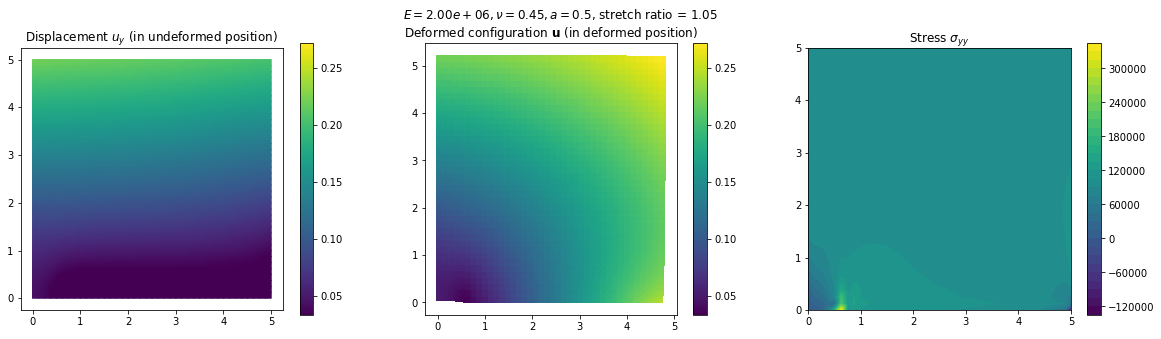

In [5]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0) and x[0]>crack_size)
    # return (on_boundary and fe.near(x[1], 0.0) ) 

# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))

# Stress function (linear elasticity)
def sigma(u):
    return lambda_*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E = 2e6
nu = 0.45  # At most 0.5

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# Crack length
crack_size = 0.5

# Externally imposed stretch ratio
stretch_ratio = 1.05  # == 1 + strain 
g = fe.Constant((0.0, E*(stretch_ratio-1))) # Surface force is a function of stretch

# Model type
# model = "plane_strain"
# if model == "plane_stress":
#     lambda_ = 2*mu*lambda_/(lambda_+2*mu)

# --------------------
# Geometry
# --------------------
# mesh = fe.Mesh("external_mesh.xml")  # Load custom mesh

### Rectangular mesh
l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 40, 40  # Number of elements
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)


# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))
top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
# u0 = fe.Expression(('-nu*x[0]*strain','0.0'), degree=1, nu = nu, strain = stretch_ratio-1)
u0 = fe.Expression(('-x[0]*strain','0.0'), degree=1, nu = nu, strain = stretch_ratio-1)
bc = fe.DirichletBC(V, u0, bottom)

# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.inner(g, u_test)*ds(1)

# --------------------
# Solver
# --------------------
u = fe.Function(V)
A_ass, L_ass = fe.assemble_system(a, l, bc)

fe.solve(A_ass, u.vector(), L_ass)

print(np.amax(u.vector()[:]))

# --------------------
# Post-process
# --------------------
# f, (ax1,ax2,ax3) = plt.subplots(1,3)
plt.figure(figsize=(20,5))
plt.suptitle('$E = {:.2e}, \\nu = {}, a = {}$, stretch ratio = {}'.format(E,nu,crack_size, stretch_ratio))

plt.subplot(1,3,1)
ax1 = fe.plot(u.sub(1),mode='color')
plt.colorbar(ax1)
plt.title('Displacement $u_y$ (in undeformed position)')



plt.subplot(1,3,2)
ax2 = fe.plot(u, mode="displacement")
plt.colorbar(ax2)
plt.title('Deformed configuration $\mathbf{u}$ (in deformed position)')
ax1.set_clim(ax2.get_clim())


plt.subplot(1,3,3)
stress = sigma(u)
V0 = fe.TensorFunctionSpace(mesh, "DG", 0)
stress_1 = fe.project(stress, V0)
ax3 = fe.plot(stress_1[1, 1])
plt.colorbar(ax3)
plt.title(r'Stress $\sigma_{yy}$')
plt.show()

# Integrate around crack tip to get J-integral



